# Introduction

Health care is moving towards a value-based care model that incentivizes health care providers for providing quality care, quantified by improvements of the patient's health outcomes. This model involves understanding the health care needs of patients, integrating a multidisciplinary team to develop solutions that impact population health, and measuring health outcomes of patients to drive ongoing quality improvement projects.

With the advent of electronic health data and recent innovations in the field of machine learning, large and complex clinical data have been used by health care professionals to have answer pressing problems. Machine learning methods have been used to improve patient risk stratification for specific infections, disease prediction, and streamlining hospital operations.

Centers for Medicare & Medicaid Services (CMS) have created various value-based programs that incentivizes health care providers to provide better care and value to patients. For instance, the [Hospital Readmission Reduction Program](https://www.cms.gov/index.php/Medicare/Quality-Initiatives-Patient-Assessment-Instruments/Value-Based-Programs/HRRP/Hospital-Readmission-Reduction-Program) focuses on improving care coordination efforts in order to reduce readmission rates, effectively saving health care costs for both the provider and the patient. 

The program defines readmission as:

1. Unplanned readmissions that happen within 30 days of discharge from the initial admission and;
2. Patients who are readmitted to the same hospital, or another applicable acute care hospital for any reason.

This notebook will focus on applying classification models to identify patients who are at risk for readmission, as defined by the HRRP. The data used for this project can be found in the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/diabetes+130-us+hospitals+for+years+1999-2008).

## Data Set Information

The data has been prepared to analyze factors related to readmission as well as other outcomes pertaining to patients with diabetes. This data has been used to study the impact of HbA1c measurement and hospital readmission rates (see [here](https://www.hindawi.com/journals/bmri/2014/781670/)).

As mentioned in the article, the data represents 10 years of clinical care at 130 US hospitals and integrated delivery networks. The data has been de-identified and each observations in the dataset satisfy the following criteria:

1. an inpatient encounter (i.e., hospital admission),
2. a diabetic encounter (i.e., any kind of diabetes has been identified as one the patient's diagnosis),
3. the length of stay was at least 1 day and at most 14 days,
4. laboratory tests were performed during the encounter and;
5. medications were administered during the encounter.

More information about the data can be found in the article in the following [link](https://www.hindawi.com/journals/bmri/2014/781670/).

# Methodology

## Data Exploration

In [1]:
# Installing packages.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Load data into a pandas dataframe.
diabetes_df = pd.read_csv("diabetic_data.csv", low_memory=False)

# Returning number of observations and features of the data.
print(f'The dataset has {diabetes_df.shape[0]} observations and {diabetes_df.shape[1]} features.')

The dataset has 101766 observations and 50 features.


In [3]:
# Returning data types for the features.
diabetes_df.dtypes.value_counts()

object    37
int64     13
dtype: int64

In [4]:
# Returning categorical features.
diabetes_df.columns[diabetes_df.dtypes == 'object']

Index(['race', 'gender', 'age', 'weight', 'payer_code', 'medical_specialty',
       'diag_1', 'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult', 'metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')

In [5]:
# Returning numerical features.
diabetes_df.columns[diabetes_df.dtypes != 'object']

Index(['encounter_id', 'patient_nbr', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient',
       'number_diagnoses'],
      dtype='object')

Of our 50 features, 37 are `object` or categorical features and 13 `int64` or numerical features. 

With a quick glance at our features, we see several things that sets a direction for our analysis:
* `diabetes_df['age']` is seen as an `object`, but should be `int64`;
* `diabetes_df['readmitted']` is our output value that will be used for our classification models;
* `diabetes_df[['encounter_id', 'patient_nbr]]` are patient identifiers that are not useful for analysis;
* `diabetes_df[['admission_type_id', 'discharge_disposition_id, 'admission_source_id']]`, are seen as `int64`, but should be `object`.

We can see that data cleaning is needed to correct our features into the proper data types and remove predictors that aren't useful for our analysis.

Let's take a closer look at our features.

In [6]:
diabetes_df = diabetes_df.drop(columns=['encounter_id', 'patient_nbr'])

### Categorical Features

In [7]:
# Assigning categorical features into a variable.
categorical_cols = diabetes_df.columns[diabetes_df.dtypes=='object']

# Assigning an array of unique values for each categorical features.
unique_cat_cols = [diabetes_df[i].unique() for i in categorical_cols]

# Creating a dataframe to view results.
pd.DataFrame({'Unique Values': unique_cat_cols}, index=categorical_cols)

,Unique Values
race,"[Caucasian, AfricanAmerican, ?, Other, Asian, ..."
gender,"[Female, Male, Unknown/Invalid]"
age,"[[0-10), [10-20), [20-30), [30-40), [40-50), [..."
weight,"[?, [75-100), [50-75), [0-25), [100-125), [25-..."
payer_code,"[?, MC, MD, HM, UN, BC, SP, CP, SI, DM, CM, CH..."
medical_specialty,"[Pediatrics-Endocrinology, ?, InternalMedicine..."
diag_1,"[250.83, 276, 648, 8, 197, 414, 428, 398, 434,..."
diag_2,"[?, 250.01, 250, 250.43, 157, 411, 492, 427, 1..."
diag_3,"[?, 255, V27, 403, 250, V45, 38, 486, 996, 197..."
max_glu_serum,"[None, >300, Norm, >200]"


From this table, we can see deduct more information about the dataset, most notably are:
* `diabetes_df[['age', 'weight']]` depict age and weight in categorical bins, so we can leave it as an `object`;
* There are `?` values, which we'll assume are missing data, thus we can treat it as `np.nan`;
* `diabetes_df[['admission_type_id', 'discharge_disposition_id, 'admission_source_id']]` are categorical values that are represented in `IDs_mapping.csv`. We need to take a closer look at `IDs_mapping.csv` to gather more information about these features;
* `diabetes_df[['diag_1', 'diag_2', 'diag_3']]` are ICD-9 codes for the patient's primary, secondary, and additional diagnoses. We need to have a meaningful categorization for these codes (i.e., Cardiovascular, Pulmonary, etc.);
* `diabetes_df[['payer_code', 'medical_specialty']]` can be omitted for our analysis;
* There are 23 features regarding any medication that were prescribed or any changes made to the patient;
* `diabetes_df['change']` succinctly represents if there any medication changes;
* `diabetes_df['diabetes_Med']` notes if there any diabetic medications prescribed to the patients;

Using this information, we can continue with our analysis.

In [8]:
# Replacing ? values with np.nan.
diabetes_df.replace('?', np.nan, inplace=True)

In [31]:
# Replacing string with np.nan.
diabetes_df['gender'].replace('Unknown/Invalid', np.nan, inplace=True)

#### Admission Type and Source & Discharge

In [9]:
# Replacing null values with np.nan.
diabetes_df['admission_type_id'] = diabetes_df['admission_type_id'].replace(
    [5, 6, 8], np.nan)

# Replacing null values with np.nan.
diabetes_df['discharge_disposition_id'] = diabetes_df['discharge_disposition_id'].replace(
    [11, 13, 14, 18, 19, 20, 21, 25, 26], np.nan)

# Replacing null values with np.nan.
diabetes_df['admission_source_id'] = diabetes_df['admission_source_id'].replace(
    [9, 15, 17, 20, 21], np.nan)

In [10]:
# Changing the features into an object data type.
diabetes_df[['admission_type_id', 'discharge_disposition_id', 'admission_source_id']] = diabetes_df[[
    'admission_type_id', 'discharge_disposition_id', 'admission_source_id']].astype('object')

Taking a closer look at `IDs_mapping.csv`, we can see how `diabetes_df[['admission_type_id', 'discharge_disposition_id', 'admission_source_id']]` are mapped.

For example, there are values that represent missing data and values that makes the patient ineligible to be readmitted.

We'll omit those observations for our analysis.

#### ICD-9 Diagnosis

In [11]:
icd_9_cols = ['diag_1', 'diag_2', 'diag_3']

In [12]:
for i in icd_9_cols:
    print(diabetes_df[i].sample(10))
    print('---'*10)

45206       410
74761    250.13
3898        414
96149       584
19120       276
17863       154
80853       820
16704       440
94952       493
95853     250.8
Name: diag_1, dtype: object
------------------------------
45957    403
16393    410
43412    428
82947    486
16663    414
51839    403
9898     250
49483    185
48958    581
46958    571
Name: diag_2, dtype: object
------------------------------
70116    250
81081    491
20187    414
25702    599
53526    781
30371    427
90526    599
5758     424
7453     250
5445     486
Name: diag_3, dtype: object
------------------------------


In our dataset, `diabetes_df[['diag_1', 'diag_2', 'diag_3']]` are ICD-9 values which has a combination of `int64`, `float64` and `object` values. Typically, it's in three character notation (i.e., `250` for diabetes mellitus). There are other instances where it could be a `float64` where it can specify additional complication of the disease (i.e., diabetes with ketoacidoses are coded from `250.10` to `250.13`). Lastly, there are codes where it's an `object` value (i.e., `V77.0` for screening for thyroid disorders).

To be useful in our analysis, we have to categorize the ICD-9 codes into meaningful classes. The CDC has provided meaning categories for analysis found [here](https://www.cdc.gov/nchs/icd/icd9cm.htm). Additionally, we will be condensing the four and five digit codes into the primary three digit code (i.e., `250.1` or `250.12` will be coded as `250`).

*Note: Future analysis will consider ICD-9 codes with added specificities of the diagnosis.*

We will use these categories as a placeholder for our diagnoses columns.

In [13]:
def cleanICDColumns(cols):
    """
    Returns a dataframe object with the primary three digit ICD-9 codes.
    
    @returns: dataframe object
    """
    # Locates and assigns all codes that has "V" or "E" with 1000
    diabetes_df.loc[((diabetes_df[cols]).str.contains('V') | (diabetes_df[cols]).str.contains('E')), [cols]] = 1000
    
    # Converts all codes into integer values
    diabetes_df[cols] = pd.to_numeric(diabetes_df[cols], errors='coerce')
    
    # Assigns 0 for null data.
    diabetes_df[cols] = diabetes_df[cols].fillna(0).astype(int)
    
    # Returns results.
    return diabetes_df[cols]

for i in icd_9_cols:
    diabetes_df[i] = cleanICDColumns(i)

In [14]:
# Loops through the ICD-9 columns and assigns a value from choices based on the conditions.
# Note: Optimization? Cleaner code?
for i in icd_9_cols:
    col = i

    # Conditions are based on ICD-9 categorization per CDC's documentation.
    conditions = [(diabetes_df[col] >= 1) & (diabetes_df[col] < 140),
                  (diabetes_df[col] >= 140) & (diabetes_df[col] < 240),
                  (diabetes_df[col] >= 240) & (diabetes_df[col] < 280),
                  (diabetes_df[col] >= 280) & (diabetes_df[col] < 290),
                  (diabetes_df[col] >= 290) & (diabetes_df[col] < 320),
                  (diabetes_df[col] >= 320) & (diabetes_df[col] < 390),
                  (diabetes_df[col] >= 390) & (diabetes_df[col] < 460),
                  (diabetes_df[col] >= 460) & (diabetes_df[col] < 520),
                  (diabetes_df[col] >= 520) & (diabetes_df[col] < 580),
                  (diabetes_df[col] >= 580) & (diabetes_df[col] < 630),
                  (diabetes_df[col] >= 630) & (diabetes_df[col] < 680),
                  (diabetes_df[col] >= 680) & (diabetes_df[col] < 710),
                  (diabetes_df[col] >= 710) & (diabetes_df[col] < 740),
                  (diabetes_df[col] >= 740) & (diabetes_df[col] < 760),
                  (diabetes_df[col] >= 760) & (diabetes_df[col] < 780),
                  (diabetes_df[col] >= 780) & (diabetes_df[col] < 800),
                  (diabetes_df[col] >= 800) & (diabetes_df[col] < 1000),
                  (diabetes_df[col] == 1000)]

    choices = ['1', '2', '3', '4', '5', '6', '7', '8', '9',
               '10', '11', '12', '13', '14', '15', '16', '17', '18']

    diabetes_df[i] = np.select(conditions, choices, default=None)

    # Assigns diagnoses columns as object data type.
    diabetes_df[i] = diabetes_df[i].astype('object')

In [15]:
# Dropping columns not useful for analysis. Maybe useful features for future analysis.
diabetes_df = diabetes_df.drop(columns=['payer_code', 'medical_specialty'])

In [16]:
# Assigning readmission status to a binary category.
readmitted_dict = {'NO': 0,
                   '>30': 0,
                   '<30': 1}

diabetes_df['readmitted'] = diabetes_df['readmitted'].map(readmitted_dict)

#### Exploratory Analysis

With our categorical features sorted, we can take a deeper look at the distributions of our features using the `seaborn` and `matplotlib.pyplot` libraries.

We can start by looking at the distribution of readmission rates of our patient population.

##### Readmission Outcome Distribution

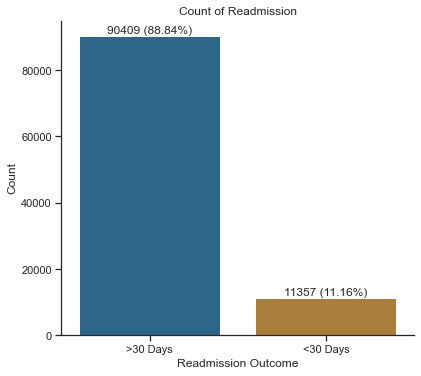

In [17]:
# Plotting readmission counts.
with sns.plotting_context(context='notebook'):
    sns.set_style('ticks')
    sns.set_palette('colorblind')
    ax_1 = sns.catplot(x='readmitted', data=diabetes_df,
                       kind='count', saturation=0.5)
    ax_1.fig.set_size_inches(6, 5)
    ax_1.set_xticklabels(['>30 Days', '<30 Days'])
    plt.title('Count of Readmission')
    plt.xlabel('Readmission Outcome')
    plt.ylabel('Count')

    # Adding labels.
    for i in ax_1.ax.patches:
        h = i.get_height()
        total = len(diabetes_df)
        count = int(h)
        ax_1.ax.text(i.get_x() + i.get_width() / 2, h + 1500, '{} ({:.2f}%)'.format(
            count, (count / total) * 100), ha='center', va='center', fontweight='medium', size=12)
    
    # Preparing figure for export.
    # plt.savefig('readmission-distribution.png', bbox_inches='tight')

11.16% of the observations were readmitted within 30 days of discharge. This poses an imbalance class problem, which can produce inaccurate predictions in classification models. We can address this problem by ensuring that the training and test data are balanced (i.e., an equal distribution of observations where `diabetes_df['readmitted'] == 0` and `diabetes_df['readmitted'] == 1`). 

### Numerical Features

In [28]:
diabetes_df.describe()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,readmitted
count,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000
mean,4.395987,43.095641,1.339730,16.021844,0.369357,0.197836,0.635566,7.422607,0.111599
std,2.985108,19.674362,1.705807,8.127566,1.267265,0.930472,1.262863,1.933600,0.314874
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000,0.000000
50%,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000,0.000000
75%,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000,0.000000
max,14.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000,16.000000,1.000000


## Data Cleaning

### Missing Values

In [35]:
def missingValuesTable(df):
    """
    Returns a dataframe object that displays number of columns with missing values, count and 
    percentage of missing values per column.

    @return dataframe :object:
    """
    # Total missing values
    missing_values = df.isnull().sum()

    # Percentage of missing values
    missing_values_pct = (missing_values * 100) / len(df)

    # Making a table with the results
    missing_table = pd.concat([missing_values, missing_values_pct], axis=1)

    # Renaming the columns
    missing_table_cols = missing_table.rename(
        columns={0: 'Count of Missing Values', 1: 'Percentage of Missing Values'})

    # Sorting the table
    missing_table_cols = missing_table_cols[missing_table_cols.iloc[:, 1] != 0].sort_values(
        'Percentage of Missing Values', ascending=False).round(2)

    # Summary information
    print(
        f'There are {str(missing_table_cols.shape[0])} column(s) that have missing value(s).')

    # Return the table with the missing information
    return missing_table_cols


missingValuesTable(diabetes_df)

There are 9 column(s) that have missing value(s).


,Count of Missing Values,Percentage of Missing Values
weight,98569,96.86
admission_type_id,10396,10.22
discharge_disposition_id,7103,6.98
admission_source_id,7067,6.94
race,2273,2.23
diag_3,1423,1.40
diag_2,358,0.35
diag_1,21,0.02
gender,3,0.00
